In [1]:
import sys
sys.path.append("../")

In [2]:
%load_ext watermark
%watermark -p torch,pandas,numpy -m

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


torch 0.4.1
pandas 0.22.0
numpy 1.15.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.10.0-32-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [3]:
from pathlib import Path
import itertools
from collections import Counter
from functools import partial, reduce

import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit
from fastai.text import (
    TextDataset, SortishSampler, SortSampler, DataLoader, ModelData, get_rnn_classifier, seq2seq_reg, 
    RNN_Learner, TextModel, to_gpu, LanguageModelLoader, LanguageModelData
)
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from fastai.text import accuracy
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import sentencepiece as spm

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
path = Path("../data/cache/lm_bpe_douban/")
path.mkdir(parents=True, exist_ok=True)

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Import And Tokenize Comments and Ratings

In [6]:
df_ratings = pd.read_csv("../data/ratings_word.csv")
df_ratings.head()

,comment,rating
0,别 拿 矫揉造作 的 资产阶级 情调 麻醉 中国 人民 ！,1
1,文青 们 向往 的 生活 ， 可是 生活 中 没有 了 喜怒哀乐 ， 没有 了 问题 与 冲...,2
2,自由 也许 在 大理 ， 生活 确实 在 别处 。,3
3,原来 八旬 是 小四 的 老公 ， 小 彩旗 的 爹 ， 杨丽萍 的 妹夫 。,3
4,关于 大理 的 蓝光 旅游 宣传片 。,3


In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=888)
train_idx, test_idx = next(sss.split(df_ratings, df_ratings.rating))
df_train = df_ratings.iloc[train_idx].copy()
df_test = df_ratings.iloc[test_idx].copy()
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=888)
val_idx, test_idx = next(sss.split(df_test, df_test.rating))
df_val = df_test.iloc[val_idx].copy()
df_test = df_test.iloc[test_idx].copy()
del df_ratings

In [8]:
UNK = 0
BEG = 1
EMB_DIM = 300

### Use the BPE Vocabulary from the Wiki model

In [9]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/bpe_model.model")

True

#### Tokenize

In [11]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + sp.EncodeAsIds(row["comment"])))

In [12]:
assert len(tokens_train) == df_train.shape[0]

In [14]:
tokens_train[0]

array([   1,   17,  265,  226, 3354,   28,  603,  956, 5043,    3,  410,   11,  218, 2900,  133,   17, 4569,
       5471,  381,    5,  133, 1670,   12,   68, 3781, 4228, 6047,    4, 4569, 6521,    3, 2937, 2376,   29,
         17,   15,    3,   40, 4452,  198,  265,   15, 1226,    5])

#### Embedding
We can keep using the original embedding matrix, but the row corresponding to the BEG token must be zeroed.

In [17]:
MODEL_PATH = "../data/cache/lm_bpe/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.encoder.weight'].shape[1] == EMB_DIM
weights['0.encoder.weight'].shape

torch.Size([7500, 300])

In [18]:
weights['0.encoder.weight'][BEG, :] = 0
weights['0.encoder_with_dropout.embed.weight'][BEG, :] = 0
weights['1.decoder.weight'][BEG, :] = 0

In [22]:
n_toks = weights['0.encoder.weight'].shape[0]

### Use the Refitted Vocabulary
#### Investigate Vocabulary Differences

In [9]:
itos_orig = []
with open("../data/bpe_model.vocab", mode="r", encoding="utf-8") as f:
    for line in f.readlines():
        itos_orig.append(line.split("\t")[0])
itos = []
with open("../data/rating_bpe_model.vocab", mode="r", encoding="utf-8") as f:
    for line in f.readlines():
        itos.append(line.split("\t")[0])
n_toks = len(itos)
n_toks

7500

In [10]:
itos[:5]

['<unk>', '<s>', '</s>', '▁,', '▁的']

In [11]:
mapping = {s: idx for idx, s in enumerate(itos)}
mapping_orig = {s: idx for idx, s in enumerate(itos_orig)}

In [12]:
voc_diff = set(itos) - set(itos_orig)
print(len(voc_diff))
sorted([(x, mapping[x]) for x in list(voc_diff)], key=lambda x: x[1], reverse=True)[:50]

[('\\', 7499),
 ('幂', 7498),
 ('拐', 7497),
 ('媳', 7496),
 ('酣', 7493),
 ('痨', 7490),
 ('澡', 7489),
 ('缚', 7487),
 ('谑', 7480),
 ('睁', 7477),
 ('懈', 7474),
 ('撸', 7467),
 ('翘', 7465),
 ('镖', 7462),
 ('疙', 7460),
 ('呕', 7458),
 ('畸', 7453),
 ('瘩', 7450),
 ('裘', 7448),
 ('嚼', 7443),
 ('磕', 7441),
 ('烘', 7440),
 ('噗', 7439),
 ('蹦', 7438),
 ('韧', 7436),
 ('撇', 7430),
 ('糅', 7428),
 ('捡', 7423),
 ('驭', 7422),
 ('咩', 7421),
 ('苟', 7420),
 ('噢', 7418),
 ('绚', 7413),
 ('苛', 7412),
 ('揍', 7410),
 ('嗷', 7407),
 ('彤', 7404),
 ('蹩', 7403),
 ('喘', 7400),
 ('掰', 7399),
 ('绽', 7398),
 ('煎', 7397),
 ('蚁', 7394),
 ('娴', 7388),
 ('❤', 7386),
 ('倦', 7385),
 ('枉', 7383),
 ('秃', 7378),
 ('͓', 7376),
 ('樟', 7375)]

#### Tokenize

In [13]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/rating_bpe_model.model")

True

In [14]:
results = []
tokens_train, tokens_val, tokens_test = [], [], []
for df, tokens in zip((df_train, df_val, df_test), (tokens_train, tokens_val, tokens_test)) :
    for i, row in tqdm_notebook(df.iterrows(), total=df.shape[0]):
        tokens.append(np.array([BEG] + sp.EncodeAsIds(row["comment"])))
assert len(tokens_train) == df_train.shape[0]        

In [15]:
tokens_val[0]

array([   1,  102,  226,  145,  855, 5447])

In [16]:
df_val.iloc[0]

comment    男 主角 像 卡卡
rating             2
Name: 681247, dtype: object

#### Prepare the embedding matrix

In [17]:
MODEL_PATH = "../data/cache/lm_bpe/models/lm_lstm.h5"
weights = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
assert weights['0.encoder.weight'].shape[1] == EMB_DIM
weights['0.encoder.weight'].shape

torch.Size([7500, 300])

In [18]:
new_matrix = np.zeros((n_toks, EMB_DIM))
hits = 0
for i, w in enumerate(itos):
    if w in mapping_orig:
        new_matrix[i] = weights['0.encoder.weight'][mapping_orig[w]]
        hits += 1
new_matrix[BEG, :] = 0
hits, hits *100 / len(itos[3:])

(4966, 66.23982926503935)

In [19]:
weights['0.encoder.weight'] = T(new_matrix)
weights['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_matrix))
weights['1.decoder.weight'] = T(np.copy(new_matrix))

## Languange Model

In [20]:
bs = 64
bptt = 50
trn_dl = LanguageModelLoader(np.concatenate(tokens_train), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(tokens_val), bs, bptt)

In [21]:
np.max(np.array(list(itertools.chain.from_iterable(tokens_train))))

7499

In [23]:
model_data = LanguageModelData(path, 2, n_toks, trn_dl, val_dl, bs=bs, bptt=bptt)

In [24]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
opt_fn = partial(torch.optim.Adam, betas=(0.8, 0.99))

In [25]:
learner = model_data.get_model(opt_fn, EMB_DIM, 500, 3, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [26]:
learner.model.load_state_dict(weights)

In [27]:
lr=1e-3
lrs = lr
learner.fit(lrs/2, 1, wds=1e-7, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      5.574285   5.365681   0.173224  



[5.365681440754651, 0.17322426804204497]

In [28]:
learner.save('lm_last_ft')

In [29]:
learner.unfreeze()
learner.clip = 25
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      5.175868   4.984307   0.201573  



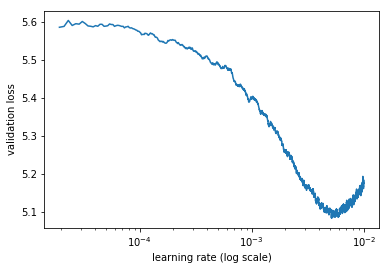

In [30]:
learner.sched.plot()

In [31]:
lr = 3e-3
lrs = lr
learner.fit(lrs, 1, wds=1e-7, use_clr=(20,5), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                     
    0      5.021575   4.815387   0.218947  
    1      4.900706   4.703487   0.228121                     
    2      4.814705   4.63053    0.235073                     
    3      4.761726   4.587876   0.239537                     
    4      4.722428   4.553373   0.243065                     
    5      4.678019   4.52396    0.246421                     
    6      4.666779   4.500108   0.248761                     
    7      4.631276   4.477508   0.251244                     
    8      4.601529   4.459368   0.253291                     
    9      4.573345   4.445579   0.254882                     



[4.445578697160617, 0.2548817738074734]

In [32]:
learner.save_encoder("lm1_enc")

In [33]:
learner.save("lm1")

In [34]:
del learner

## 3-class Classifier
As in https://zhuanlan.zhihu.com/p/27198713

### Full Dataset (v1)

In [35]:
for df in (df_train, df_val, df_test):
    df["label"] = (df["rating"] >= 3) * 1
    df.loc[df.rating == 3, "label"] = 1
    df.loc[df.rating > 3, "label"] = 2

In [36]:
df_train.label.value_counts()

2    240094
1    184124
0    104406
Name: label, dtype: int64

In [37]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.label.values)
val_ds = TextDataset(tokens_val, df_val.label.values)
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [38]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [39]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=2,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [40]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 81%|████████  | 13351/16520 [02:21<00:33, 94.06it/s, loss=2.09] 

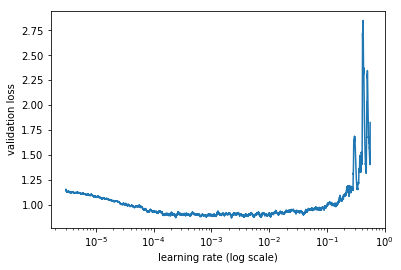

In [41]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [42]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.877199   0.846573   0.597799  


[0.8465732022244502, 0.5977991918641605]

In [43]:
learn.save('clas_0')

In [44]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                        
    0      0.878488   0.834733   0.604802  


[0.8347334080232561, 0.6048022791246709]

In [45]:
learn.save('clas_1')

In [46]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                        
    0      0.873368   0.818094   0.613758  
    1      0.875838   0.802078   0.624364                        
    2      0.810573   0.789708   0.63097                         
    3      0.815987   0.783285   0.635334                        
    4      0.820386   0.779947   0.635754                        
    5      0.798186   0.772996   0.640641                        
    6      0.804235   0.77394    0.640754                        
    7      0.777555   0.770229   0.641815                        
    8      0.791138   0.76694    0.644136                        
    9      0.798625   0.76671    0.643983                        
    10     0.800009   0.765702   0.644227                        
    11     0.784685   0.765501   0.643717                        
    12     0.774107   0.761692   0.646844                        
    13     0.786844   0.761889   0.646367                        


[0.7618894243147266, 0.6463667937891583]

In [47]:
learn.save("clas_full")

#### Evaluate

In [48]:
learn.load("clas_full")
learn.model.reset()
_ = learn.model.eval()

In [49]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(val_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [50]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176208,), (176208,))

In [51]:
pd.Series(ys).value_counts()

2    80031
1    61374
0    34803
dtype: int64

In [52]:
pd.Series(preds).value_counts()

2    94777
1    51586
0    29845
dtype: int64

In [53]:
np.sum(ys==preds) / ys.shape[0]

0.6463667937891583

In [54]:
np.where(ys==0)

(array([    11,     13,     20, ..., 176198, 176202, 176207]),)

In [55]:
tokens_val[176196]

array([   1,  438,    4, 4370,    3, 1324,   13,   22,   19, 2869, 4935,    8,    3,   12,  119,  278])

In [56]:
sp.DecodeIds(tokens_val[176196].tolist()), df_val["comment"].iloc[176196]

('如此 的 欺骗 , 或许 我 也 就 释然 了 , 有 什么 呢', '如此 的 欺骗 ， 或许 我 也 就 释然 了 ， 有 什么 呢')

In [57]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()

In [58]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

array([[ 0.32267,  0.15441, -1.12714]], dtype=float32)

In [59]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

array([[-1.25038, -0.77775,  2.06884]], dtype=float32)

In [60]:
get_prediction("说 实话 我 没 怎么 认真 看 ， 电影院 里 的 熊 孩子 太 闹腾 了 ， 前面 的 小奶娃 还 时不时 站 "
               "在 老爸 腿上 蹦迪 ， 观影 体验 极差 ， 不过 小朋友 应该 挺 喜欢 的")

array([[-0.68478,  0.8484 ,  0.3501 ]], dtype=float32)

In [61]:
get_prediction("这 电影 太 好笑 了 ， 说好 的 高科技 人才 研制 的 产品 永远 在 关键 时候 失灵 "
               "； 特地 飞 到 泰国 请来 救援 人才 ， 大家 研究 出 的 方法 每次 都是 先 给 鲨鱼 "
               "当 诱饵 … … 显然 这样 的 对战 坚持不了 多久 ， 只能 赶紧 让 鲨鱼 输 了 。")

array([[-1.10724, -0.07409,  1.11315]], dtype=float32)

In [62]:
get_prediction("太 接地气 了 ， 在 三亚 煮饺子 式 的 景区 海域 ， 冒出来 一条 大 鲨鱼 "
               "… … 爽点 也 很 密集 ， 郭达森 与 李冰冰 的 CP 感 不错 ， 编剧 果然 是 "
               "老外 ， 中文 台词 有点 尬 。")

array([[-0.81838,  0.64474,  0.20536]], dtype=float32)

In [63]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

array([[0.0482, 0.6378, 0.0901]], dtype=float32)

In [64]:
get_prediction("太 难 了 。 。 。")

array([[ 0.83333, -0.14575, -0.93784]], dtype=float32)

In [65]:
get_prediction("把 我 基神 写成 智障 ， 辣鸡 mcu")

array([[0.18405, 0.00303, 0.38519]], dtype=float32)

In [66]:
get_prediction("鲨鱼 部分 还是 不错 的 ， 尤其 是 中段 第一次 出海 捕鲨 非常 刺激 ， 其后 急速 下滑 ， "
               "三亚 那 部分 拍得 是什么 鬼 。 。 。 爆米花 片 可以 适度 的 蠢 ， 但 人类 反派 炸鲨 "
               "和 直升机 相撞 部分 简直 蠢得 太过份 了 吧 ？ 另外 充满 硬 加戏 视感 的 尴尬 感情戏 "
               "把 节奏 也 拖垮 了 ， 明明 可以 更 出色 ， 却 很遗憾 地 止步 在 马马虎虎 的 水平 。 6 / 10")

array([[ 0.05863,  1.47022, -2.15057]], dtype=float32)

In [67]:
get_prediction("老冰冰 真的 很努力 ！ 为 老冰冰 实现 了 她 的 好莱坞 女主梦 鼓掌 . . .")

array([[-1.55147,  0.3827 ,  0.85495]], dtype=float32)

In [68]:
get_prediction("结局 简直 丧 出 天际 ！ 灭霸 竟然 有 内心戏 ！ 全程 下来 美队 "
               "和 钢铁侠 也 没 见上 一面 ， 我 还 以为 在 世界 末日 前 必然 "
               "要 重修 旧好 了 ！ ")

array([[-0.79738,  0.32011,  0.54841]], dtype=float32)

In [69]:
get_prediction("太 烂 了 ， 难看 至极 。")

array([[ 3.67361, -2.02026, -2.06235]], dtype=float32)

In [70]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

array([[ 0.55792, -0.14219, -2.20485]], dtype=float32)

In [71]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

array([[ 0.32463,  0.33998, -0.83547]], dtype=float32)

In [72]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

array([[-0.28512, -0.00981,  0.40679]], dtype=float32)

In [73]:
get_prediction("还 我 电影票 14 元")

array([[ 0.53262, -0.11861, -0.33267]], dtype=float32)

Confusion matrix, without normalization
[[19572  9857  5374]
 [ 7758 29268 24348]
 [ 2515 12461 65055]]


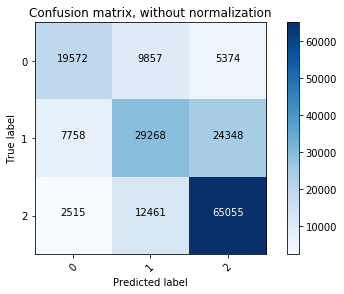

In [74]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.56 0.28 0.15]
 [0.13 0.48 0.4 ]
 [0.03 0.16 0.81]]


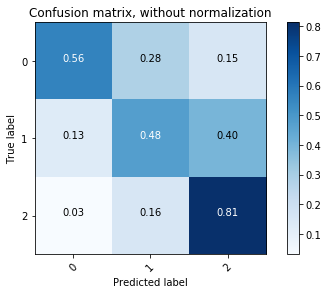

In [75]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [76]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 66%, R 56%, FS 0.61, Support: 34803
Class 1: P 57%, R 48%, FS 0.52, Support: 61374
Class 2: P 69%, R 81%, FS 0.74, Support: 80031


In [77]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [78]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [79]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [80]:
np.sum(ys==preds) / ys.shape[0]

0.6457558921507982

Confusion matrix, without normalization
[[19351  9898  5553]
 [ 7780 29383 24212]
 [ 2500 12478 65054]]


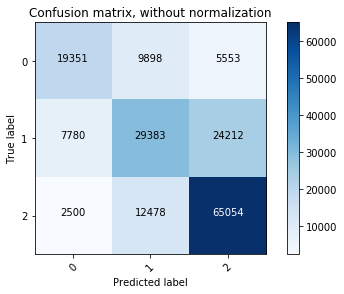

In [81]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.56 0.28 0.16]
 [0.13 0.48 0.39]
 [0.03 0.16 0.81]]


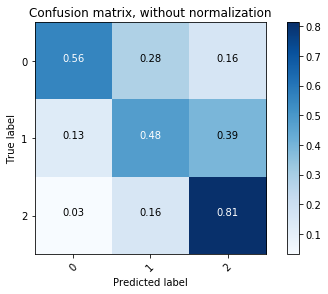

In [82]:
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [83]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 65%, R 56%, FS 0.60, Support: 34802
Class 1: P 57%, R 48%, FS 0.52, Support: 61375
Class 2: P 69%, R 81%, FS 0.74, Support: 80032


### Smaller Dataset 

In [84]:
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [85]:
df_train_small = pd.concat([
    df_train[df_train.label==0].sample(15000),
    df_train[df_train.label==1].sample(15000),
    df_train[df_train.label==2].sample(15000)
], axis=0)
df_val_small = pd.concat([
    df_val[df_val.label==0].sample(5000),
    df_val[df_val.label==1].sample(5000),
    df_val[df_val.label==2].sample(5000)
], axis=0)

In [86]:
np.array(df_train_small.index)

array([147325, 153829, 412170, ..., 299822, 390010, 284728])

In [87]:
bs = 64
tokens_train_small = np.array(tokens_train)[np.array(df_train_small.index)]
tokens_val_small = np.array(tokens_val)[np.array(df_val_small.index)]
trn_ds = TextDataset(tokens_train_small, df_train_small.label.values)
val_ds = TextDataset(tokens_val_small, df_val_small.label.values)
trn_samp = SortishSampler(tokens_train_small, key=lambda x: len(tokens_train_small[x]), bs=bs//2)
val_samp = SortSampler(tokens_val_small, key=lambda x: len(tokens_val_small[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [88]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [89]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 3], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [90]:
learn = RNN_Learner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]
learn.load_encoder('lm1_enc')

 82%|████████▏ | 1152/1407 [00:12<00:02, 91.40it/s, loss=2.94]

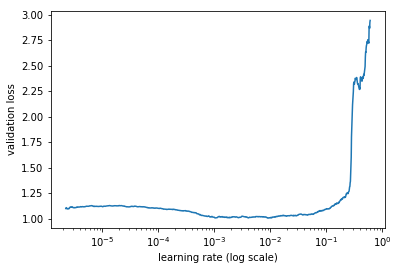

In [91]:
learn.freeze_to(-1)
learn.lr_find(lrs/100)
learn.sched.plot()

In [92]:
lr=1e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.997599   0.916898   0.559467  


[0.91689831199646, 0.5594666666666667]

In [93]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.993326   0.898027   0.570267  


[0.8980265075365702, 0.570266666730245]

In [94]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                      
    0      0.965662   0.887376   0.5722    
    1      0.959765   0.875815   0.583267                      
    2      0.947525   0.863386   0.589733                      
    3      0.94881    0.859881   0.5914                        
    4      0.922522   0.85288    0.593133                      
    5      0.932415   0.850652   0.596067                      
    6      0.898998   0.850368   0.597333                      
    7      0.910517   0.846687   0.5996                        
    8      0.907697   0.846573   0.597333                      
    9      0.922122   0.842931   0.601333                      
    10     0.907489   0.844452   0.600467                      
    11     0.911997   0.84151    0.601533                      
    12     0.902386   0.840759   0.6028                        
    13     0.886464   0.841385   0.6028                        


[0.8413845752239227, 0.6028]

In [95]:
learn.save("clas_small_full")

In [96]:
learn.model.eval()
preds, ys = [], []
for x, y in val_dl:
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [97]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((15000,), (15000,))

Normalized confusion matrix
[[0.69 0.19 0.12]
 [0.26 0.41 0.33]
 [0.1  0.19 0.71]]


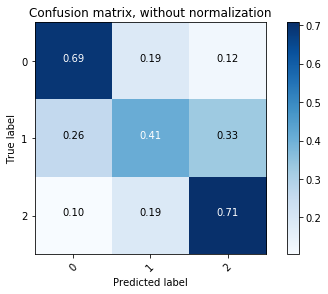

In [98]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [99]:
test_ds = TextDataset(tokens_test, df_test.label.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [100]:
learn.model.eval()
preds, ys = [], []
for x, y in tqdm_notebook(test_dl):
    preds.append(np.argmax(learn.model(x)[0].cpu().data.numpy(), axis=1))
    ys.append(y.cpu().numpy())

In [101]:
preds = np.concatenate(preds)
ys = np.concatenate(ys)
preds.shape, ys.shape

((176209,), (176209,))

In [102]:
np.sum(preds==ys) / preds.shape[0]

0.5976595974098939

Normalized confusion matrix
[[0.68 0.2  0.12]
 [0.26 0.41 0.33]
 [0.11 0.18 0.71]]


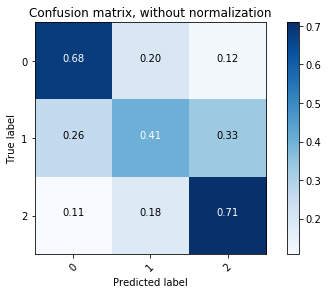

In [103]:
cnf_matrix = confusion_matrix(ys, preds)
np.set_printoptions(precision=2)
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2], normalize=True,
    title='Confusion matrix, without normalization')

In [104]:
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds)
for i in range(3):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 49%, R 68%, FS 0.57, Support: 34802
Class 1: P 54%, R 41%, FS 0.46, Support: 61375
Class 2: P 70%, R 71%, FS 0.70, Support: 80032


## Regressor

In [105]:
bs = 64
trn_ds = TextDataset(tokens_train, df_train.rating.values.astype("float32"))
val_ds = TextDataset(tokens_val, df_val.rating.values.astype("float32"))
trn_samp = SortishSampler(tokens_train, key=lambda x: len(tokens_train[x]), bs=bs//2)
val_samp = SortSampler(tokens_val, key=lambda x: len(tokens_val[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=0, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=val_samp)
model_data = ModelData(path, trn_dl, val_dl)

In [106]:
dps = np.array([0.4,0.5,0.05,0.3,0.4]) * 0.5
opt_fn = partial(torch.optim.Adam, betas=(0.7, 0.99))
bptt = 50

In [107]:
model = get_rnn_classifier(bptt, bptt*2, 3, n_toks, emb_sz=EMB_DIM, n_hid=500, n_layers=3, pad_token=0,
          layers=[EMB_DIM*3, 50, 1], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [108]:
class RNN_RegLearner(RNN_Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)

    def _get_crit(self, data): return lambda x, y: F.mse_loss(x[:, 0], y)

In [109]:
learn = RNN_RegLearner(model_data, TextModel(to_gpu(model)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = []
learn.load_encoder('lm1_enc')

In [110]:
lr=2e-4
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

 81%|████████  | 13327/16520 [02:36<00:37, 85.23it/s, loss=1.61] 

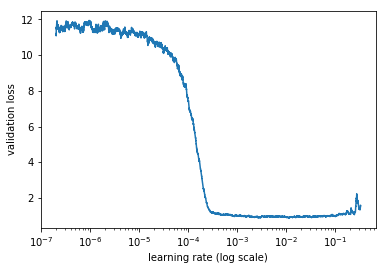

In [111]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [112]:
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_0')

epoch      trn_loss   val_loss                                    
    0      0.897428   0.80347   


In [113]:
learn.freeze_to(-2)
learn.fit(lrs, 1, wds=0, cycle_len=1, use_clr=(8,3))
learn.save('reg_1')

epoch      trn_loss   val_loss                                   
    0      0.878112   0.782759  


In [114]:
learn.unfreeze()
learn.fit(lrs, 1, wds=0, cycle_len=14, use_clr=(32,10))
learn.save('reg_full')

epoch      trn_loss   val_loss                                   
    0      0.825059   0.758064  
    1      0.822395   0.734133                                   
    2      0.79041    0.714603                                   
    3      0.813912   0.701953                                   
    4      0.76007    0.693665                                   
    5      0.751937   0.686725                                   
    6      0.74664    0.683355                                   
    7      0.776315   0.677879                                   
    8      0.70007    0.678511                                   
    9      0.729849   0.67697                                    
    10     0.763175   0.676528                                   
    11     0.723679   0.682628                                   
    12     0.729367   0.67069                                    
    13     0.722551   0.671593                                   


In [115]:
# Export Model
torch.save(learn.model, path / "sentiment_model.pth")

In [116]:
learn.load('reg_full')

### Evaluation

In [117]:
test_ds = TextDataset(tokens_test, df_test.rating.values)
test_samp = SortSampler(tokens_test, key=lambda x: len(tokens_test[x]))
test_dl = DataLoader(test_ds, bs, transpose=True, num_workers=1, pad_idx=0, sampler=test_samp)

In [118]:
def get_preds(data_loader):
    learn.model.eval()
    learn.model.reset()         
    preds, ys = [], []
    for x, y in tqdm_notebook(data_loader):   
        preds.append(learn.model(x)[0].cpu().data.numpy()[:, 0])
        ys.append(y.cpu().numpy())
    preds = np.concatenate(preds)
    ys = np.concatenate(ys)
    return ys, preds
ys, preds = get_preds(val_dl)
preds.shape, ys.shape

((176208,), (176208,))

In [119]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [120]:
pd.Series(ys).describe()

count    176208.000000
mean          3.335331
std           1.080536
min           1.000000
25%           3.000000
50%           3.000000
75%           4.000000
max           5.000000
dtype: float64

In [121]:
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6715929735738445

In [122]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6686593844348724

In [123]:
# Save predictions
df_val.loc[df_val.iloc[list(iter(val_samp))].index, "preds"] = preds
df_val.to_csv(path / "df_val.csv.gz", index=False, compression="gzip")
df_val.head()

,comment,rating,label,preds
0,男 主角 像 卡卡,2,0,3.406548
1,经典 改编 ， 还是 忠于 原著 的 ， 一路 都 很 稳 。,4,2,4.037384
2,叙事 ： 时间 空间 的 有机 结合,5,2,3.910672
3,看 街头 小 混混 打 外星人 挺 热闹 的 ， 可是 前 一 秒 还 在 抢劫 的 少年犯...,2,0,2.473254
4,这 电影 也 就 一般,3,1,2.519496


In [124]:
np.sum(np.square(df_val.rating.values - df_val.preds.values)) / preds.shape[0]

0.6686592716906075

In [125]:
ys, preds = get_preds(test_dl)
preds.shape, ys.shape

((176209,), (176209,))

In [126]:
preds = np.clip(preds, 1, 5)
np.sum(np.square(preds - ys)) / preds.shape[0]

0.6721334770029384

In [127]:
# Save predictions
df_test.loc[df_test.iloc[list(iter(test_samp))].index, "preds"] = preds
df_test.to_csv(path / "df_test.csv.gz", index=False, compression="gzip")
df_test.head()

,comment,rating,label,preds
258461,无话可说 .,3,1,2.635060
118491,老师 你 太 可爱,5,2,4.199808
44768,说 了 好多 话 ， 可惜 都 是 陈词滥调 、 无 凭 无据 。,2,0,2.699512
34630,普巴 家用 的 电脑 是 苹果 。,3,1,3.328828
382761,这 才 是 一 部 看 完 之后 观众 讲 不 清道 不 明 的 电影 ， 主线 不 明了 ...,4,2,2.835775


In [128]:
df_test.sample(20)

,comment,rating,label,preds
618813,女主 不错 ~ ~ 现在 老 了 之后 就 不敢恭维 了,4,2,3.038160
613203,美国 主旋律 电影 ， 以小见大 ， 史诗感 强烈 。,3,1,3.863387
69230,今年 要 去 朝鲜 体验 生活 四川 看熊 猫宝宝 云南 寻找 梦 里 禅达 ， 熊猫宝宝 ...,5,2,4.317477
354346,很 无聊 的 快餐式 动作 片,2,0,2.418192
270439,我 这么 多年 一直 没 理解 的 事情 就是 徐静蕾 有 什么 好 吹捧 的 她 有 个 ...,1,0,2.975994
2429,有 一 段 访许 鞍华 ， 她 很 真诚 ， 了解 她 越 多 ， 越 不好意思 批评 她 ...,3,1,3.733805
542649,评分 真 高 ， 反正 我 就是 看 不 下去 这 类 的 ， 没辙 。,2,0,3.031882
44958,年轻 的 女性 导演 将 一个 丰盈 而 温润 的 杨牧拍 得 有 诗人 气 ， 有 学者 ...,4,2,3.937144
545905,“ 我 当 过 真正 的 超级 英雄 吗 ？ 我 只是 向 世界 展示 了 这种 意图 ， ...,5,2,4.105260
437704,再 精心 的 算计 ， 对于 变幻不定 的 命运 来说 都 是 枉然 的 。 剧本 还 可以...,3,1,3.193131


In [129]:
np.sum(np.square(df_test.rating.values - df_test.preds.values)) / preds.shape[0]

0.6721334770029385

In [130]:
preds_class = np.round(preds)

Confusion matrix, without normalization
[[ 2355  4832  3534   761    40]
 [ 1006  8384 11680  2182    28]
 [  155  5458 36265 19229   268]
 [   19   814 16157 35840  1819]
 [   21   295  3838 17833  3396]]


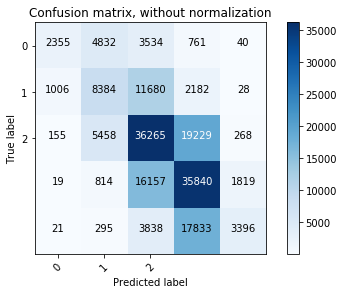

In [131]:
cnf_matrix = confusion_matrix(ys, preds_class)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=[0, 1, 2],
    title='Confusion matrix, without normalization')

In [132]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(ys, preds_class)
for i in range(5):
    print(f"Class {i}: P {precision[i]*100:.0f}%, R {recall[i]*100:.0f}%, FS {fscore[i]:.2f}, Support: {support[i]}")

Class 0: P 66%, R 20%, FS 0.31, Support: 11522
Class 1: P 42%, R 36%, FS 0.39, Support: 23280
Class 2: P 51%, R 59%, FS 0.55, Support: 61375
Class 3: P 47%, R 66%, FS 0.55, Support: 54649
Class 4: P 61%, R 13%, FS 0.22, Support: 25383


In [133]:
def get_prediction(texts):
    input_tensor = T(np.array([1] + sp.EncodeAsIds(texts))).unsqueeze(1)
    return learn.model(input_tensor)[0].data.cpu().numpy()[0, 0]

In [134]:
get_prediction("看 了 快 一半 了 才 发现 是 mini 的 广告")

2.3652477

In [135]:
get_prediction("妈蛋 ， 简直 太 好看 了 。 最后 的 DJ battle 部分 ， 兴奋 的 我 ， 简直 想 从 座位 上 站 起来 一起 扭")

4.5539985

In [136]:
get_prediction("关键点 都 好傻 ， 我 知道 你 要拍 续集 ， "
               "我 知道 未来 可以 被 重写 ， 但 那 一拳 真的 有点 傻 。")

2.4437895

In [137]:
get_prediction("李冰冰 的 脸 真的 很 紧绷 ， 比 鲨鱼 的 脸 还 绷 。")

2.8564546

In [138]:
get_prediction("太 烂 了 ， 难看 至极 。")

1.4278924

In [139]:
get_prediction("看完 之后 很 生气 ！ 剧情 太差 了")

2.2684188

In [140]:
get_prediction("好了 可以 了 。 再也 不看 Marvel 了 。 我 努力 过 了 。 实在 是 。 。 啥呀 这是 。 🙄️")

3.5063078

In [141]:
get_prediction("还 我 电影票 14 元")

2.790194